In [1]:
!pipreqs . --savepath ./requirements.txt --encoding=utf8 --force --ignore .venv,__pycache__

/bin/bash: line 1: pipreqs: command not found


In [46]:
## Importing required libraries
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve, auc
)
import shap

In [3]:
## Read in the file
url = 'https://raw.githubusercontent.com/Renzie74/motor-claims-model/refs/heads/main/data/Kenyan_Motor_Insurance_2023_2024.csv'
df = pd.read_csv(url)
df.head()

,Year,Policy_ID,Customer_Age,Gender,Region,Vehicle_Type,Vehicle_Age,Vehicle_Value_KES,Vehicle_Engine_Capacity,Use_Purpose,Annual_Premium_KES,Claims_Frequency,Total_Claim_Amount_KES,No_Claim_Bonus_%,Accident_Cause,Policy_Term_Months,Previous_Claims_Count,Driver_Experience_Years,Third_Party_Only,Claims_Status
0,2023,P202300001,58,Male,Nakuru,PSV,19,3229084,2000,Business,203851,1,866500,0,Theft,6,0,38,Yes,1
1,2023,P202300002,43,Male,Thika,Private,3,1739911,2000,Taxi,64471,0,0,20,NaN,6,2,22,No,0
2,2023,P202300003,40,Male,Kakamega,Private,0,2781931,1500,Business,146378,0,0,50,NaN,12,0,22,Yes,0
3,2023,P202300004,46,Male,Nakuru,Private,9,1154811,2500,Personal,59810,0,0,30,NaN,12,0,26,No,0
4,2023,P202300005,63,Female,Nakuru,Commercial,19,3452991,1000,Business,143266,0,0,30,NaN,6,0,41,No,0


##Exploratory Data Analysis

In [4]:
##Checking data shape
df.shape

(2000, 20)

In [5]:
##checking column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year                     2000 non-null   int64 
 1   Policy_ID                2000 non-null   object
 2   Customer_Age             2000 non-null   int64 
 3   Gender                   2000 non-null   object
 4   Region                   2000 non-null   object
 5   Vehicle_Type             2000 non-null   object
 6   Vehicle_Age              2000 non-null   int64 
 7   Vehicle_Value_KES        2000 non-null   int64 
 8   Vehicle_Engine_Capacity  2000 non-null   int64 
 9   Use_Purpose              2000 non-null   object
 10  Annual_Premium_KES       2000 non-null   int64 
 11  Claims_Frequency         2000 non-null   int64 
 12  Total_Claim_Amount_KES   2000 non-null   int64 
 13  No_Claim_Bonus_%         2000 non-null   int64 
 14  Accident_Cause           662 non-null   

In [6]:
##Checking for missing values
df.isnull().sum()

,0
Year,0
Policy_ID,0
Customer_Age,0
Gender,0
Region,0
Vehicle_Type,0
Vehicle_Age,0
Vehicle_Value_KES,0
Vehicle_Engine_Capacity,0
Use_Purpose,0


In [7]:
##Checking for duplicates
df.duplicated().value_counts()

,count
False,2000


In [8]:
df['Claims_Status'].value_counts()

,count
Claims_Status,
0,1338
1,662


<Axes: xlabel='Claims_Status', ylabel='count'>

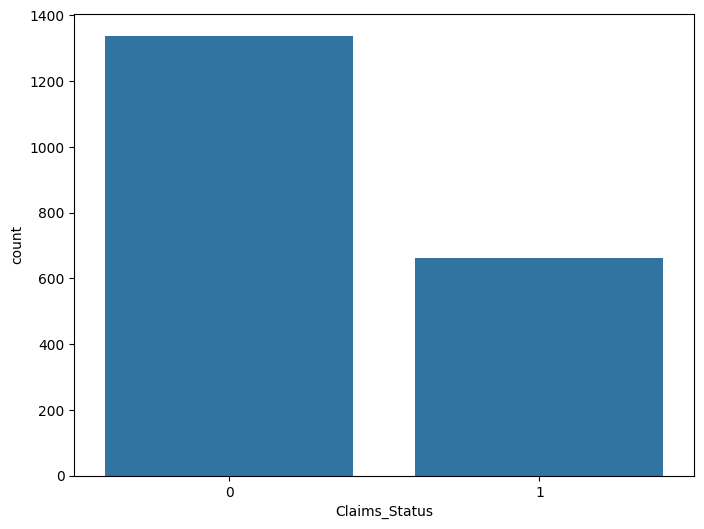

In [9]:
# Creating a count plot to visualize the distribution of claim status
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Claims_Status')

In [10]:
##Grouping by Frequeny of claims against the status to understand the distribution
df.groupby('Claims_Status')['Claims_Frequency'].value_counts()

Claims_Status  Claims_Frequency
0              0                   1338
1              1                    529
               2                    114
               3                     17
               4                      1
               5                      1
Name: count, dtype: int64

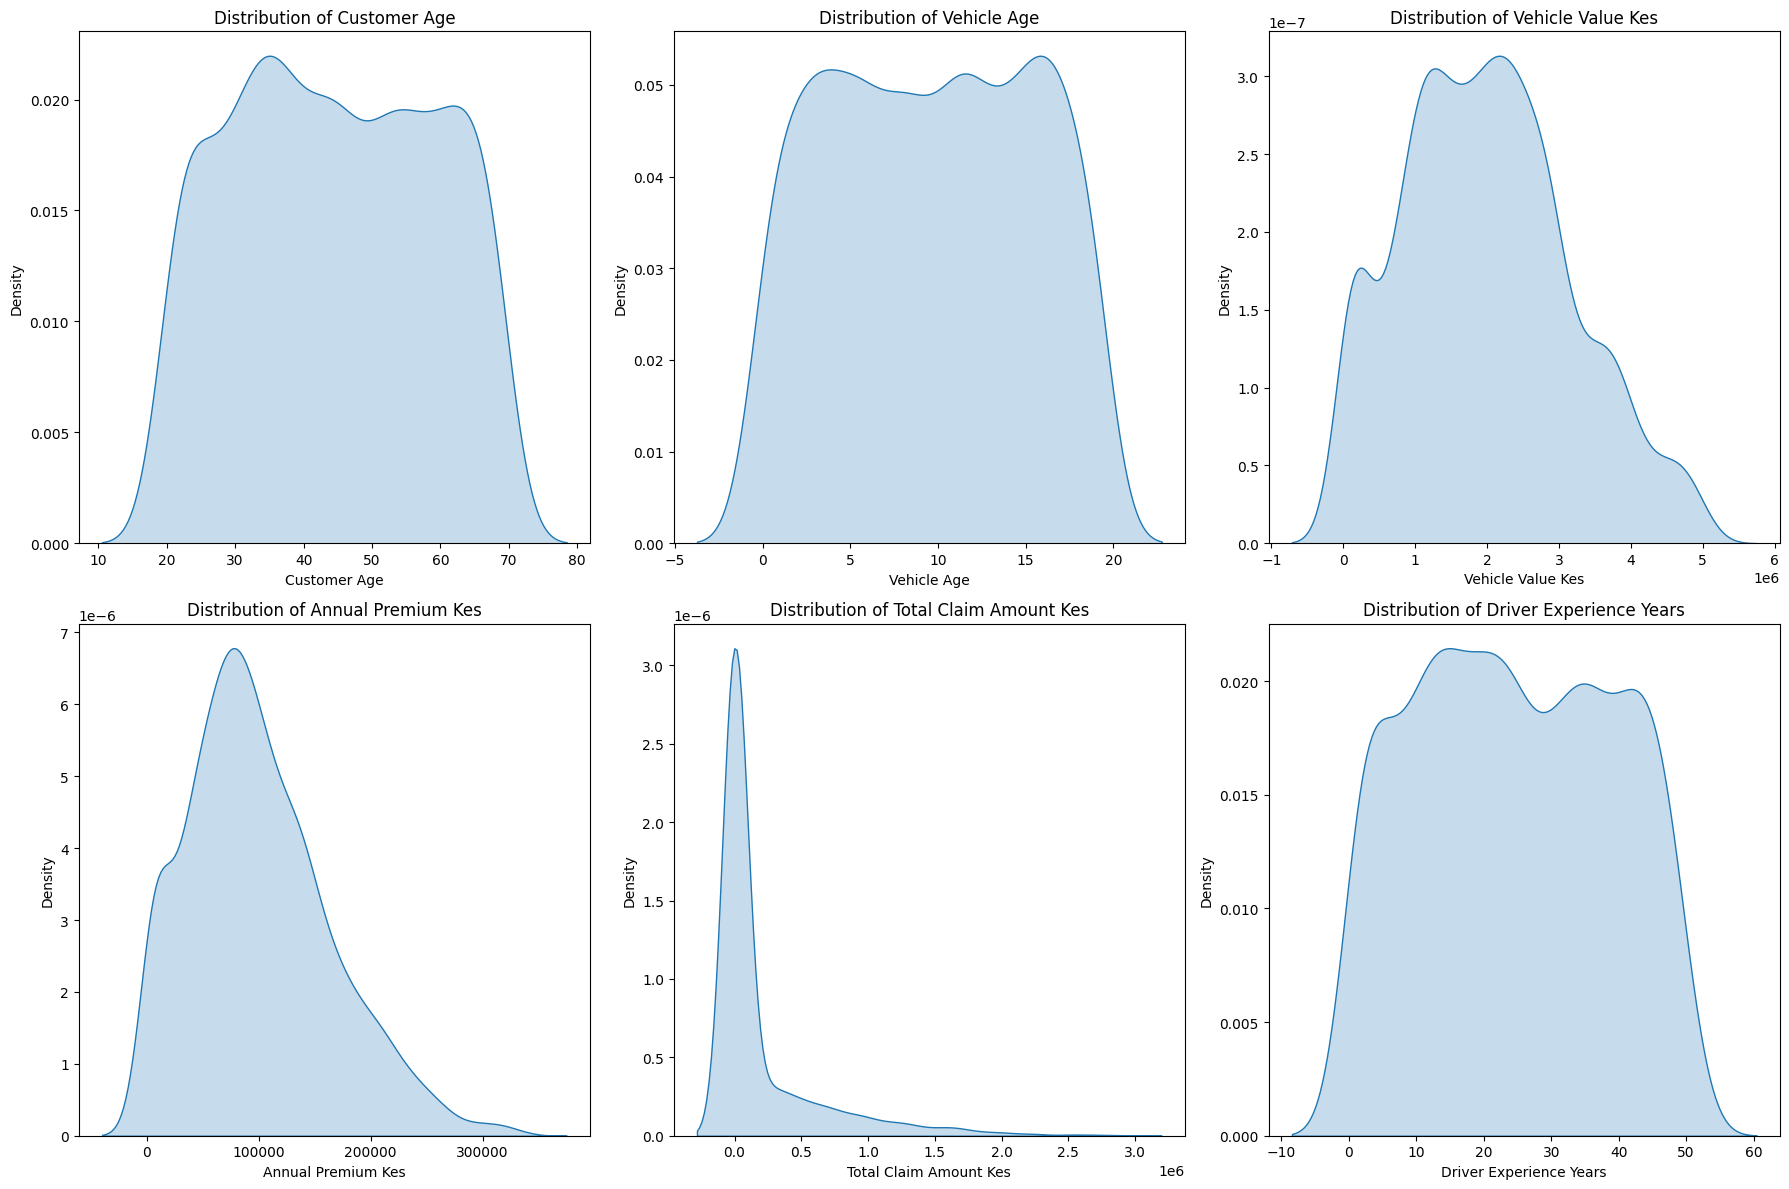

In [11]:
##Defining numerical columns and plotting distributions
numerical = df.select_dtypes(include=['int64']).drop(columns=['Claims_Status', 'Policy_Term_Months', 'Year','Vehicle_Engine_Capacity','Claims_Frequency','No_Claim_Bonus_%','Previous_Claims_Count']).columns

num_cols = len(numerical)
rows = math.ceil(num_cols / 3)

plt.figure(figsize=(18, 12))

for i, col in enumerate(numerical, 1):
  plt.subplot(rows, 3, i)

  sns.kdeplot(df[col], fill=True)

  title = " ".join([x.title() for x in col.split("_")])
  plt.title(f"Distribution of {title}")
  plt.xlabel(title)

plt.tight_layout()
plt.show()

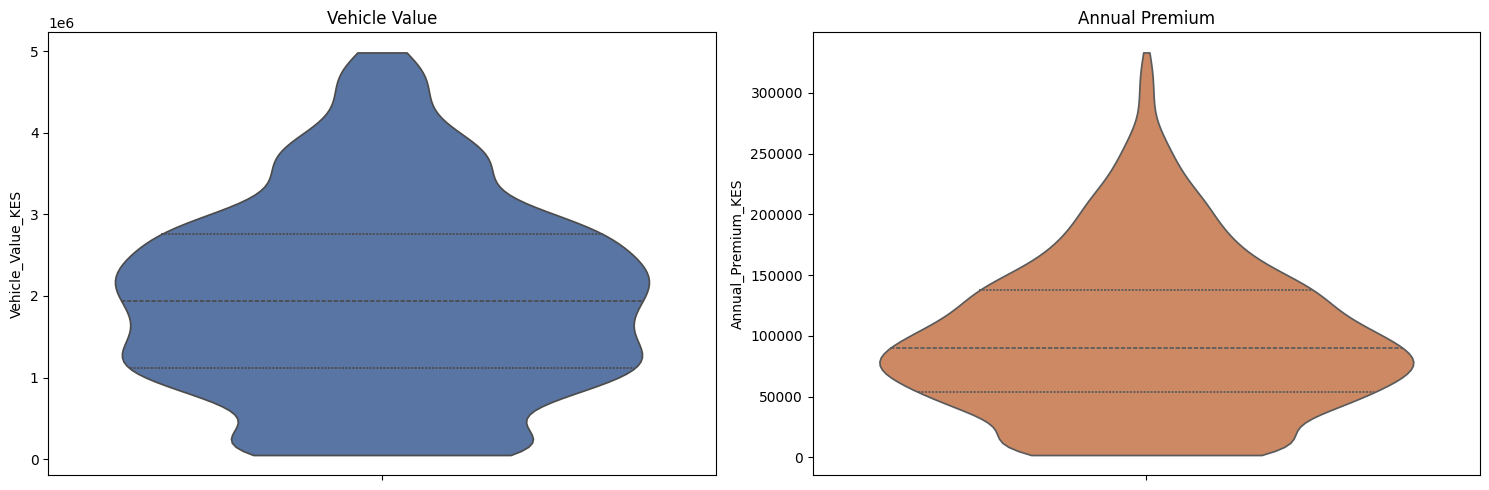

In [12]:
##Plotting Violin Plot for data distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
palette = ["#4C72B0", "#DD8452"]
sns.violinplot(
  y=df['Vehicle_Value_KES'],
  ax=axes[0],
  color=palette[0],
  inner="quartile",
  cut=0
)
axes[0].set_title('Vehicle Value')

sns.violinplot(
  y=df['Annual_Premium_KES'],
  ax=axes[1],
  color=palette[1],
  inner="quartile",
  cut=0
)
axes[1].set_title('Annual Premium')

plt.tight_layout()
plt.show()


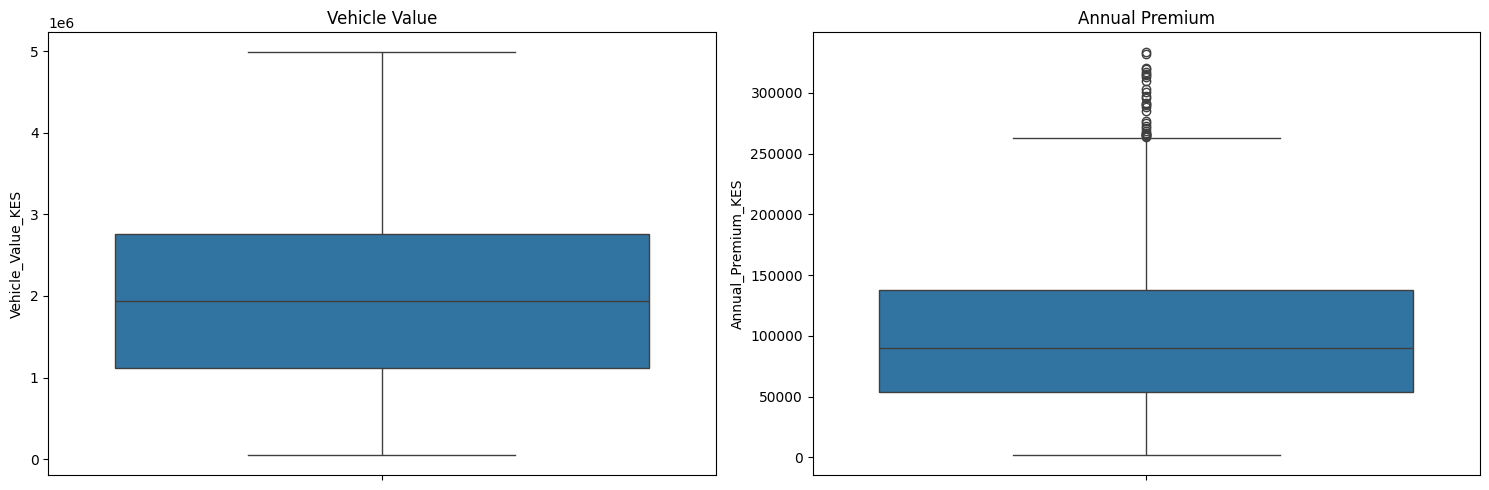

In [13]:
##Plotting a boxplot to check for outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y=df['Vehicle_Value_KES'], ax=axes[0])
axes[0].set_title('Vehicle Value')

sns.boxplot(y=df['Annual_Premium_KES'], ax=axes[1])
axes[1].set_title('Annual Premium')

plt.tight_layout()
plt.show(

)

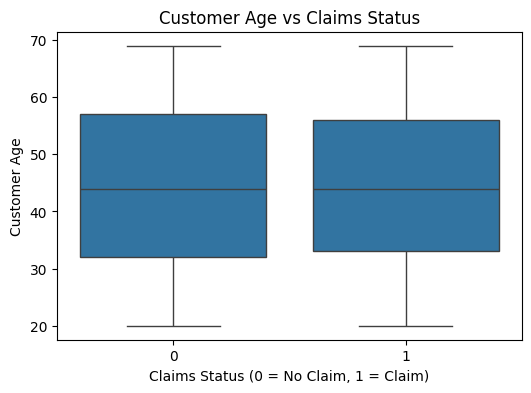

In [14]:
##Univariate analysis of Customer Age and Claim Status
plt.figure(figsize=(6, 4))
sns.boxplot(
  x="Claims_Status",
  y="Customer_Age",
  data=df
)
plt.title("Customer Age vs Claims Status")
plt.xlabel("Claims Status (0 = No Claim, 1 = Claim)")
plt.ylabel("Customer Age")
plt.show()


/tmp/ipython-input-2196309431.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claim_rate_age = df.groupby("Customer_Age_Band")["Claims_Status"].mean()


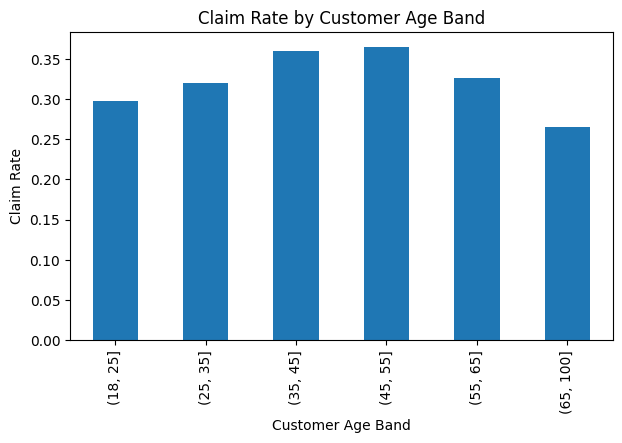

In [15]:
##Defining Age bins and plotting against Claims Rate
df["Customer_Age_Band"] = pd.cut(
  df["Customer_Age"],
  bins=[18, 25, 35, 45, 55, 65, 100]
)

claim_rate_age = df.groupby("Customer_Age_Band")["Claims_Status"].mean()

claim_rate_age.plot(kind="bar", figsize=(7, 4))
plt.title("Claim Rate by Customer Age Band")
plt.ylabel("Claim Rate")
plt.xlabel("Customer Age Band")
plt.show()

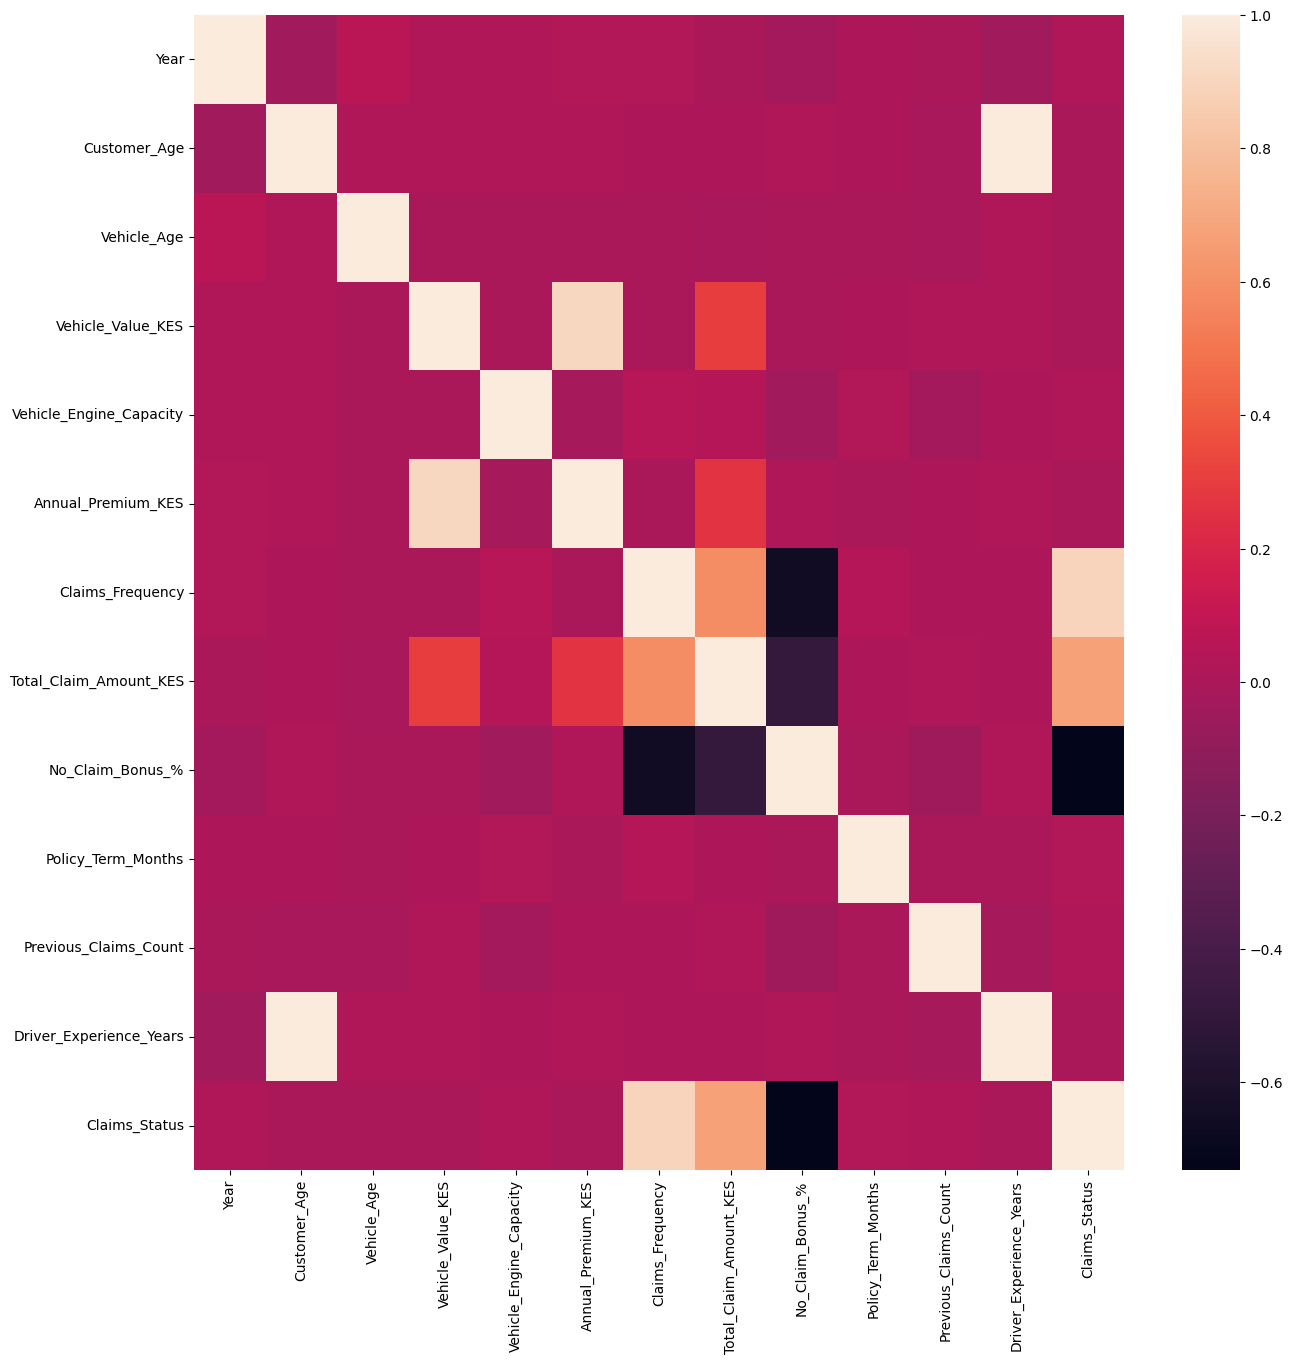

In [16]:
#checking the most correlated variables to Claims status
num_columns = df.select_dtypes(include = ["int64", "float"]).columns
correlation_matrix = df[num_columns].corr()
plt.figure(figsize = (15,15))
sns.heatmap(correlation_matrix)
plt.show()

In [17]:
##List of the top 5 most correlated variables to the claim status
top_corr = correlation_matrix['Claims_Status'].sort_values(ascending = False)
top_corr.head(n=5)

,Claims_Status
Claims_Status,1.000000
Claims_Frequency,0.893330
Total_Claim_Amount_KES,0.670176
Policy_Term_Months,0.029640
Previous_Claims_Count,0.025467


## Data Preprocessing & Feature Engineering

In [18]:
##Dropping the accident cause column
df.drop(columns=['Accident_Cause'], inplace =True)

In [19]:
df.head()

,Year,Policy_ID,Customer_Age,Gender,Region,Vehicle_Type,Vehicle_Age,Vehicle_Value_KES,Vehicle_Engine_Capacity,Use_Purpose,Annual_Premium_KES,Claims_Frequency,Total_Claim_Amount_KES,No_Claim_Bonus_%,Policy_Term_Months,Previous_Claims_Count,Driver_Experience_Years,Third_Party_Only,Claims_Status,Customer_Age_Band
0,2023,P202300001,58,Male,Nakuru,PSV,19,3229084,2000,Business,203851,1,866500,0,6,0,38,Yes,1,"(55, 65]"
1,2023,P202300002,43,Male,Thika,Private,3,1739911,2000,Taxi,64471,0,0,20,6,2,22,No,0,"(35, 45]"
2,2023,P202300003,40,Male,Kakamega,Private,0,2781931,1500,Business,146378,0,0,50,12,0,22,Yes,0,"(35, 45]"
3,2023,P202300004,46,Male,Nakuru,Private,9,1154811,2500,Personal,59810,0,0,30,12,0,26,No,0,"(45, 55]"
4,2023,P202300005,63,Female,Nakuru,Commercial,19,3452991,1000,Business,143266,0,0,30,6,0,41,No,0,"(55, 65]"


In [20]:
##drop policy_id, unique identifier of a policy to reduce bias of individual claim characteristics on model
df.drop(columns=['Policy_ID'], inplace =True)

In [21]:
##Create a copy of the initial data
df_copy = df.copy()

In [22]:
##Identifying columns for encoding
categorical_cols = df_copy.select_dtypes(include='object').columns
numerical_cols = df_copy.select_dtypes(exclude='object').columns
One_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = One_hot.fit_transform(df_copy[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=One_hot.get_feature_names_out(categorical_cols), index=df_copy.index)
df_encoded = pd.concat([df_copy[numerical_cols], encoded_df], axis=1)

In [23]:
df_encoded.head()

,Year,Customer_Age,Vehicle_Age,Vehicle_Value_KES,Vehicle_Engine_Capacity,Annual_Premium_KES,Claims_Frequency,Total_Claim_Amount_KES,No_Claim_Bonus_%,Policy_Term_Months,...,Region_Thika,Vehicle_Type_Commercial,Vehicle_Type_Motorcycle,Vehicle_Type_PSV,Vehicle_Type_Private,Use_Purpose_Business,Use_Purpose_Personal,Use_Purpose_Taxi,Third_Party_Only_No,Third_Party_Only_Yes
0,2023,58,19,3229084,2000,203851,1,866500,0,6,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2023,43,3,1739911,2000,64471,0,0,20,6,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,2023,40,0,2781931,1500,146378,0,0,50,12,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,2023,46,9,1154811,2500,59810,0,0,30,12,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,2023,63,19,3452991,1000,143266,0,0,30,6,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [24]:
df_encoded.groupby('Claims_Status')['No_Claim_Bonus_%'].describe()


,count,mean,std,min,25%,50%,75%,max
Claims_Status,,,,,,,,
0,1338.0,27.660688,14.838395,10.0,12.5,30.0,50.0,50.0
1,662.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [25]:
#Separating X and Y target features and dropping columns likely to result in data leakage
X = df_encoded.drop(columns = ['Claims_Status','Claims_Frequency', 'Previous_Claims_Count','Total_Claim_Amount_KES','No_Claim_Bonus_%', 'Customer_Age_Band'])
y = df_encoded['Claims_Status']

In [26]:
#Split Data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Train_size:', X_train.shape, y_train.shape)
print('Test_size:', X_test.shape, y_test.shape)

Train_size: (1600, 27) (1600,)
Test_size: (400, 27) (400,)


## Training Baseline Models

In [27]:
##Logistic Regression
lr_model = LogisticRegression(random_state = 42)

#Scaling Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled =  scaler.transform(X_test)


lr_model.fit(x_train_scaled, y_train)
y_pred_lr = lr_model.predict(x_test_scaled)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       256
           1       0.00      0.00      0.00       144

    accuracy                           0.64       400
   macro avg       0.32      0.50      0.39       400
weighted avg       0.41      0.64      0.50       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
def plot_auc_and_confusion_matrix(y_true_train, y_pred_proba_train, y_pred_train, y_true_test, y_pred_proba_test, y_pred_test):
  auc_train = roc_auc_score(y_true_train, y_pred_proba_train)
  auc_test = roc_auc_score(y_true_test, y_pred_proba_test)

  print(f"Training AUC: {auc_train:.2f}")
  print(f"Test AUC: {auc_test:.2f}")

  plt.figure(figsize=(15, 5))

  # Confusion Matrix for Training
  plt.subplot(1, 2, 1)
  cm_train = confusion_matrix(y_true_train, y_pred_train)
  disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
  disp_train.plot(ax=plt.gca(), cmap='Blues')
  plt.title('Training Confusion Matrix')

  # Confusion Matrix for Test
  plt.subplot(1, 2, 2)
  cm_test = confusion_matrix(y_true_test, y_pred_test)
  disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
  disp_test.plot(ax=plt.gca(), cmap='Blues')
  plt.title('Test Confusion Matrix')

  plt.tight_layout()
  plt.show()

Training AUC: 1.00
Test AUC: 0.47


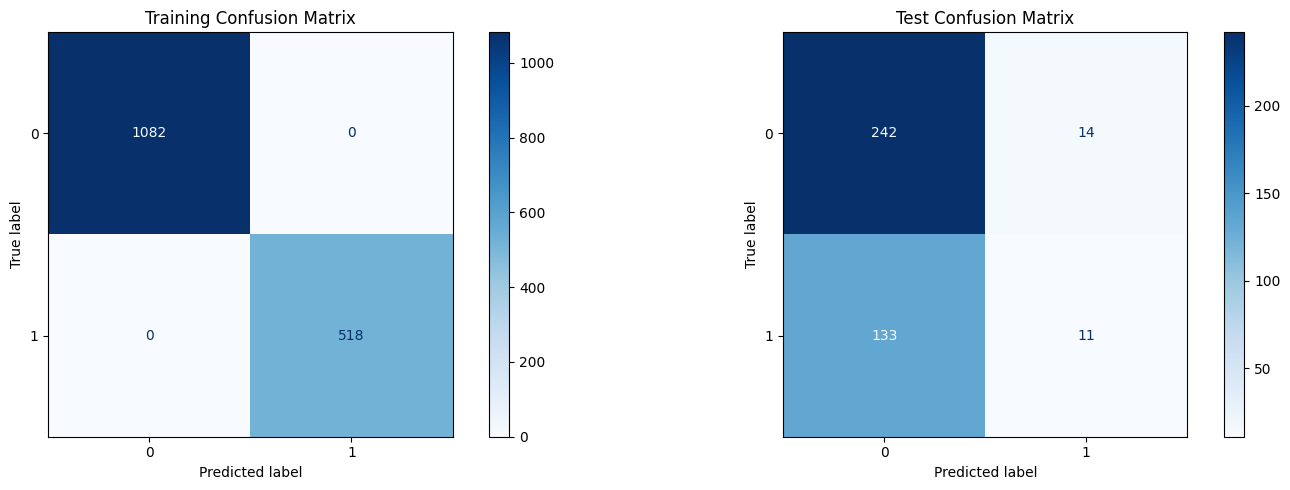

In [29]:
#Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)
y_pred_rf  = rf_clf.predict(X_train)
y_proba_rf = rf_clf.predict_proba(X_train)[:, 1]


y_pred_randomf_train    = rf_clf.predict(X_train)
y_proba_randomf_train   = rf_clf.predict_proba(X_train)[:, 1]

y_pred_randomf_test   = rf_clf.predict(X_test)
y_proba_randomf_test  = rf_clf.predict_proba(X_test)[:, 1]


plot_auc_and_confusion_matrix(y_train, y_proba_randomf_train, y_pred_randomf_train, y_test, y_proba_randomf_test, y_pred_randomf_test)

In [30]:
#Evaluating the model
print(classification_report(y_test, y_pred_randomf_test))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77       256
           1       0.44      0.08      0.13       144

    accuracy                           0.63       400
   macro avg       0.54      0.51      0.45       400
weighted avg       0.57      0.63      0.54       400



## Class Balancing


In [31]:
# Defining Models
models = {
"Random Forest": RandomForestClassifier(
random_state=42,
class_weight=None
),
"Gradient Boosting": GradientBoostingClassifier(
random_state=42
),
"AdaBoost": AdaBoostClassifier(
random_state=42
)
}

In [32]:
## Defining Samplers
samplers = {
"Random Oversampling": RandomOverSampler(random_state=42),
"SMOTE": SMOTE(random_state=42, k_neighbors=5),
"ADASYN": ADASYN(random_state=42, n_neighbors=5)
}

In [33]:

all_results = []

# Model training and evaluation
for model_name, model in models.items():
    for sampler_name, sampler in samplers.items():

        pipeline = Pipeline([
            ("sampler", sampler),
            ("model", model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        report = classification_report(
            y_test,
            y_pred,
            output_dict=True
        )

        # Storing metrics for minority class
        all_results.append({
            "Model": model_name,
            "Sampler": sampler_name,
            "Precision_1": report["1"]["precision"],
            "Recall_1": report["1"]["recall"],
            "F1_1": report["1"]["f1-score"],
            "Support_1": report["1"]["support"],
            "Accuracy": report["accuracy"]
        })


In [34]:
results_df = pd.DataFrame(all_results)
results_df.sort_values(by="F1_1", ascending=False)

,Model,Sampler,Precision_1,Recall_1,F1_1,Support_1,Accuracy
3,Gradient Boosting,Random Oversampling,0.353293,0.409722,0.379421,144.0,0.5175
6,AdaBoost,Random Oversampling,0.323699,0.388889,0.353312,144.0,0.4875
0,Random Forest,Random Oversampling,0.381818,0.145833,0.211055,144.0,0.6075
8,AdaBoost,ADASYN,0.395833,0.131944,0.197917,144.0,0.6150
1,Random Forest,SMOTE,0.341463,0.097222,0.151351,144.0,0.6075
2,Random Forest,ADASYN,0.325581,0.097222,0.149733,144.0,0.6025
5,Gradient Boosting,ADASYN,0.391304,0.062500,0.107784,144.0,0.6275
4,Gradient Boosting,SMOTE,0.320000,0.055556,0.094675,144.0,0.6175
7,AdaBoost,SMOTE,0.750000,0.020833,0.040541,144.0,0.6450


In [35]:
## Model training and evaluation
for model_name, model in models.items():
  print(f"\n================ {model_name} ================")
  for sampler_name, sampler in samplers.items():
    pipeline = Pipeline([
      ("sampler", sampler),
      ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n--- {sampler_name} ---")
    print(classification_report(y_test, y_pred))


================ Random Forest ================

--- Random Oversampling ---
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       256
           1       0.38      0.15      0.21       144

    accuracy                           0.61       400
   macro avg       0.51      0.51      0.47       400
weighted avg       0.55      0.61      0.55       400


--- SMOTE ---
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       256
           1       0.34      0.10      0.15       144

    accuracy                           0.61       400
   macro avg       0.49      0.50      0.45       400
weighted avg       0.53      0.61      0.53       400


--- ADASYN ---
              precision    recall  f1-score   support

           0       0.64      0.89      0.74       256
           1       0.33      0.10      0.15       144

    accuracy                           0.60       400
   macro avg       

### The results above show that accuracy for most models was fairly high as compared to the other metrics which are more critical for imbalanced data such as F1 Score and recall. This falls in line with studies which show that accuracy paradox tends to skew overall model performance by focusing on the majority class but missing out on the correct classification of the minority claims class. By ranking the performance of model and sampler combinations using F1 Score, boosting models performed fairly better than the baseline.


## Hyperparameter tuning

In [36]:
## Defining Parameter grids
param_grids = {
"Random Forest": {
'model__n_estimators': [100, 300, 500],
'model__max_depth': [None, 5, 10, 20],
'model__min_samples_split': [2, 5, 10],
'model__min_samples_leaf': [1, 2, 4],
'model__max_features': ['sqrt', 'log2']
},

"Gradient Boosting": {
'model__n_estimators': [100, 200],
'model__learning_rate': [0.01, 0.05, 0.1],
'model__max_depth': [3, 5],
'model__subsample': [0.8, 1.0],
'model__min_samples_leaf': [1, 5]
},

"AdaBoost": {
'model__n_estimators': [50, 100, 200],
'model__learning_rate': [0.01, 0.05, 0.1, 1.0]
    }
}


In [37]:
## Defining models
models = {
"Random Forest": RandomForestClassifier(random_state=42),
"Gradient Boosting": GradientBoostingClassifier(random_state=42),
"AdaBoost": AdaBoostClassifier(random_state=42)
}

In [38]:
param_distributions = param_grids[model_name]

In [39]:
## Applying Stratified cross validation for class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [40]:
## Training the tuned models
tuned_models = {}

for sampler_name, sampler in samplers.items():
    for model_name, model in models.items():

        pipeline = Pipeline([
            ('sampler', sampler),
            ('model', model)
        ])

        search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_grids[model_name],
            n_iter=30,
            scoring='f1',
            cv=cv,
            n_jobs=-1,
            random_state=42,
            verbose=0

        )

        search.fit(X_train, y_train)

    tuned_models[f"{model_name}_{sampler_name}"] = {
    'best_estimator': search.best_estimator_,
    'best_params': search.best_params_,
    'best_score': search.best_score_
}

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [41]:
##Tuning the threshholds to improve recall for the minority class
best_model_name_sampler = None
max_f1_score = -1

for key, value in tuned_models.items():
    if value['best_score'] > max_f1_score:
        max_f1_score = value['best_score']
        best_model_name_sampler = key

best_model = tuned_models[best_model_name_sampler]['best_estimator']

y_probs = best_model.predict_proba(X_test)[:, 1]

for t in [0.3, 0.4, 0.5]:
    y_pred = (y_probs >= t).astype(int)
    print(f"Threshold {t}")
    print(classification_report(y_test, y_pred))

Threshold 0.3
              precision    recall  f1-score   support

           0       0.75      0.05      0.09       256
           1       0.36      0.97      0.53       144

    accuracy                           0.38       400
   macro avg       0.56      0.51      0.31       400
weighted avg       0.61      0.38      0.25       400

Threshold 0.4
              precision    recall  f1-score   support

           0       0.66      0.24      0.35       256
           1       0.37      0.78      0.50       144

    accuracy                           0.43       400
   macro avg       0.51      0.51      0.43       400
weighted avg       0.56      0.43      0.40       400

Threshold 0.5
              precision    recall  f1-score   support

           0       0.67      0.39      0.50       256
           1       0.38      0.66      0.48       144

    accuracy                           0.49       400
   macro avg       0.53      0.53      0.49       400
weighted avg       0.57      0.4

## Hyperparameter tuning was conducted for the top-performing model–sampler combinations identified during baseline evaluation, namely Gradient Boosting and AdaBoost with Random Oversampling. GridSearchCV was applied using F1-score as the optimization criterion to balance precision and recall for the minority claims class. Additionally, classification thresholds were adjusted post-training to further improve recall, reflecting the cost of misclassification in insurance claims prediction.

In [42]:
## Evaluating on Test set
for name, result in tuned_models.items():
    best_estimator = result['best_estimator']
    y_pred_tuned = best_estimator.predict(X_test)
    print(f"\n============== Evaluation for {name} ==============")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Best Cross-Validation AUC: {result['best_score']:.4f}")
    print(classification_report(y_test, y_pred_tuned))


============== Evaluation for AdaBoost_Random Oversampling ==============
Best Parameters: {'model__n_estimators': 100, 'model__learning_rate': 0.05}
Best Cross-Validation AUC: 0.4441
              precision    recall  f1-score   support

           0       0.47      0.03      0.06       256
           1       0.35      0.94      0.51       144

    accuracy                           0.36       400
   macro avg       0.41      0.48      0.29       400
weighted avg       0.43      0.36      0.22       400


============== Evaluation for AdaBoost_SMOTE ==============
Best Parameters: {'model__n_estimators': 50, 'model__learning_rate': 0.01}
Best Cross-Validation AUC: 0.4382
              precision    recall  f1-score   support

           0       0.67      0.39      0.50       256
           1       0.38      0.66      0.48       144

    accuracy                           0.49       400
   macro avg       0.53      0.53      0.49       400
weighted avg       0.57      0.49      0.49   

## The tuned AdaBoost models exhibit distinct trade-offs depending on the oversampling strategy employed. Random Oversampling achieved the highest recall of 0.94 and F1-score for the minority class, indicating strong sensitivity to claim detection, although at the cost of low overall accuracy and majority class recall. In contrast, SMOTE and ADASYN produced more balanced performance across classes, with moderate recall and improved accuracy.

In [43]:
## Defining Thresholds
thresholds = [0.3, 0.4, 0.5]


In [44]:
## Defining the results table
from sklearn.metrics import classification_report

final_results = []

for key, value in tuned_models.items():

    model = value['best_estimator']
    y_probs = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_probs)


    model_name, sampler_name = key.split("_", 1)

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        report = classification_report(
            y_test,
            y_pred,
            output_dict=True
        )

        final_results.append({
            "Model": model_name,
            "Sampler": sampler_name,
            "Threshold": t,
            "Precision_1": report["1"]["precision"],
            "Recall_1": report["1"]["recall"],
            "F1_1": report["1"]["f1-score"],
            "Accuracy": report["accuracy"],
            "ROC_AUC": roc_auc
        })


In [45]:
## Printing out the results table
final_results_df = pd.DataFrame(final_results)

final_results_df.sort_values(
    by=["F1_1", "Recall_1"],
    ascending=False
)


,Model,Sampler,Threshold,Precision_1,Recall_1,F1_1,Accuracy,ROC_AUC
6,AdaBoost,ADASYN,0.3,0.364583,0.972222,0.530303,0.3800,0.506592
0,AdaBoost,Random Oversampling,0.3,0.355499,0.965278,0.519626,0.3575,0.471164
1,AdaBoost,Random Oversampling,0.4,0.355499,0.965278,0.519626,0.3575,0.471164
2,AdaBoost,Random Oversampling,0.5,0.352480,0.937500,0.512334,0.3575,0.471164
7,AdaBoost,ADASYN,0.4,0.366883,0.784722,0.500000,0.4350,0.506592
3,AdaBoost,SMOTE,0.3,0.380000,0.659722,0.482234,0.4900,0.503513
4,AdaBoost,SMOTE,0.4,0.380000,0.659722,0.482234,0.4900,0.503513
5,AdaBoost,SMOTE,0.5,0.380000,0.659722,0.482234,0.4900,0.503513
8,AdaBoost,ADASYN,0.5,0.380000,0.659722,0.482234,0.4900,0.506592


## Feature Importance

In [49]:
## Defining SHAP explainer
explainer = shap.Explainer(best_model.predict_proba, X_train)

In [50]:
## Fitting Shap explainer on the X-test
shap_values = explainer.shap_values(X_test)


PermutationExplainer explainer: 401it [03:01,  2.14it/s]


/tmp/ipython-input-3098829059.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


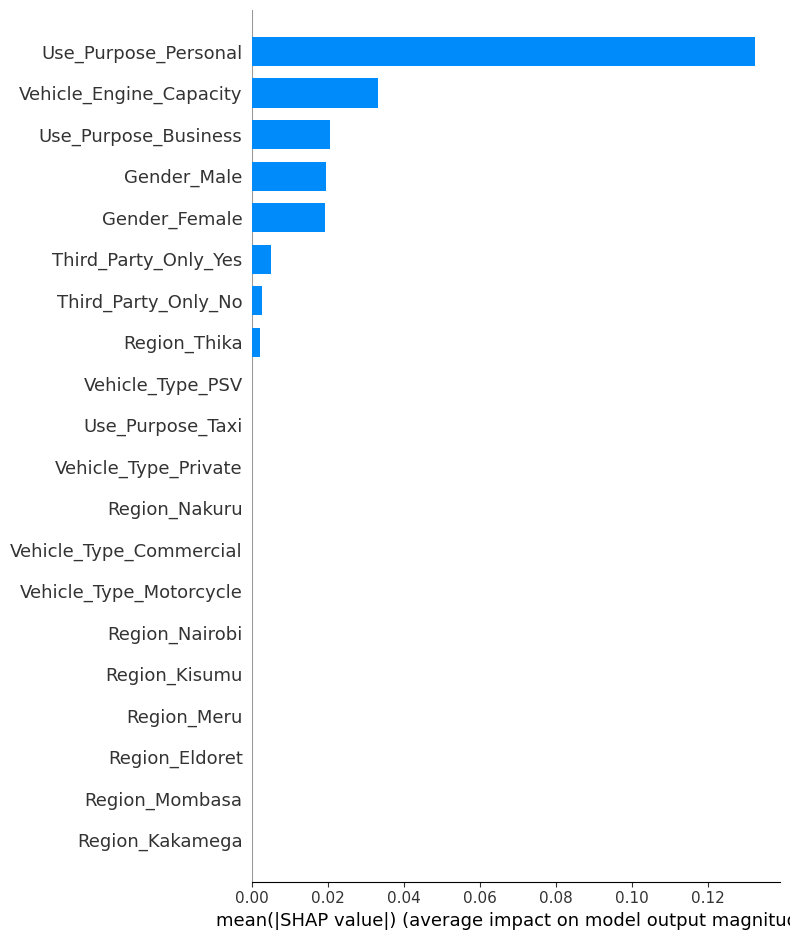

In [52]:
## Plotting feature importance
shap.summary_plot(
    shap_values[:, :, 1],
    X_test,
    plot_type="bar"
)

## SHAP analysis indicates that vehicle use purpose is the most influential predictor of claim occurrence, followed by engine capacity and coverage characteristics. The dominance of use purpose variables suggests strong behavioral risk segmentation within the portfolio

/tmp/ipython-input-72003941.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


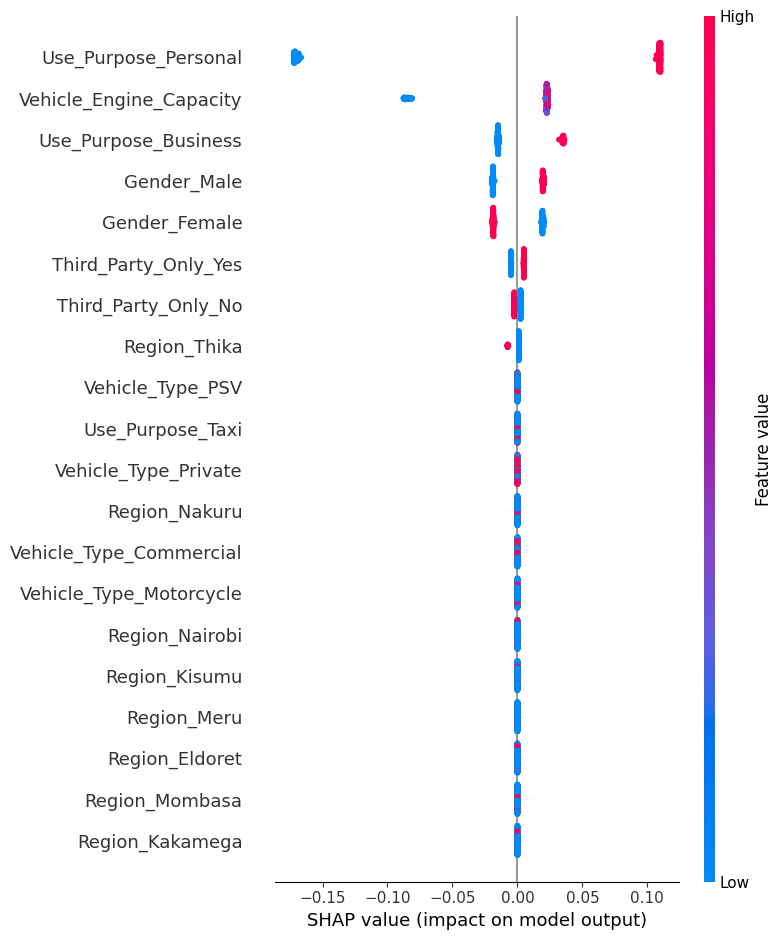

In [55]:
## Defining magnitude and direction of feature importance
shap.summary_plot(
    shap_values[:, :, 1],
    X_test
)


## SHAP dependence analysis shows that personal vehicle use strongly increases claim probability while higher engine capacity further amplifies risk. Gender and vehicle usage related variables exhibit moderate directional effects, while geographic and vehicle type features contribute minimally.